<h1><center>Projeto 1


MC934B/MO436A

2s 2023
                 
Reinforcement Learning  

Israel Silva | Jorge Frasson | Juliano Soares | Mario Costa
</center></h1>

<h1><center>Especificação dos problemas</center></h1>
<p align="justify"> As técnicas de aprendizado de máquina estão cada vez mais em uso nos dias de hoje, tais técnicas vem corroborando com a evolução de diversas áreas como: robótica, medicina, engenharia, entre outras; Podemos citar um exemplo na medicina atráves do reconhecimento de cancer de pele por meio de técnicas de aprendizado de máquina. Dentro da área de aprendizado uma área que vem sendo utilizada é a técnica de aprendizado de máquina por reforço. Que é o foco do nosso estou para esta atividade.</p>
<p align="justify">A técnica de aprendizado por reforço consiste no treinamento de modelos de aprendizado de máquina que poderiam parecer com treinamento supervisionado -- ser humano interage informando se a decisão tomada está certa ou errada; Porém o que faz a máquina decidir é como você programa as recompensas que ela irá ganhar em cada acerto ou erro. Esse modelo faz com que a máquina tome a sua própria decisão tentando maximizar os ganhos.</p>
<p align="justify">Este modelo tem sido utilizado para ambientes não determinísticos em que exite uma alta complexidade nas ações tomadas, como por exemplo, a robótica, que possui um grau de extrema dificuldade em determinar o resultado de um único passo de um robo, quem dirá prever todas as ações externas que ele pode estar sofrendo como por exemplo uma ventania.   </p>
<p align="justify">Para aplicar as técnicas propostas pelo trabalho, criamos um desafio que consiste em, um ambiente com um espaço limitado a X por Y (pode ser configurado), que permite a inserção de barreiras que não podem ser transpostas. O ambiente também vai possuir uma origem e um destino, esta distância (origem/destino). Este traçado deverá ser percorrido por um determinado bloco ,que vamos chamar de Bob, que deverá aprender o caminho, porém o Bob deverá percorrer de maneira deterministica que implica em um treinamento e execução no mesmo ambiente, assim como, no estocástico, treinamento em um ambiente mas execução em um ambiente desconhecido. Desta forma a melhor política irá levar Bob para casa no menor número de passos.</p>
<p align="justify">O trabalho proposto irá explorar 3 técnicas: Monte Carlo, Qlearning, Sarsa e montar uma avaliação entre as técnicas utilizadas tendo como base de descoberta o ambiente descrito acima.</p>

<h1><center>Entrada de dados</center></h1>
<p align="justify">A solução apresentada para executar as atividades propostas pelo trabalho foram: Python e algumas bibliotécas apresentadas na importação das bibliotécas. O sistema está arquitetado de forma que para execução basta que o usuário apenas siga a sequência execução das funções propostas.</p>   
    

## 1) Código comum para todos os algorítmos de RL utilizados

### 1.1) Instalação das Bibliotecas

In [22]:
# !pip install gymnasium
# !pip install numpy
# !pip install pygame
# !pip install random
# !pip install tqdm
# !pip install matplotlib

### 1.2) Importação das Bibliotecas

In [23]:
%matplotlib inline

import gymnasium as gym
import numpy as np
import pygame
import matplotlib.pyplot as plt
import time
import sys
import math
import pandas as pd
import os
from ast import literal_eval

### 1.3) Ambiente gráfico do labirinto

In [24]:
class MazeGameEnv(gym.Env):
    def __init__(self, maze):
        super(MazeGameEnv, self).__init__()
        self.maze = np.array(maze)
        self.start_pos = tuple(np.argwhere(self.maze == 'S')[0])
        self.goal_pos = tuple(np.argwhere(self.maze == 'G')[0])
        self.current_pos = self.start_pos
        self.num_rows, self.num_cols = self.maze.shape

        # Define ação como Discrete com 4 ações (cima, baixo, esquerda, direita)
        self.action_space = gym.spaces.Discrete(4)

        # Defina o espaço de observação como uma tupla com o número de linhas e colunas
        self.observation_space = gym.spaces.Tuple((gym.spaces.Discrete(self.num_rows), gym.spaces.Discrete(self.num_cols)))
    
        # Define atraso de renderização (em ms)
        self.delay = 0

        # Defina cores
        self.WHITE = (255, 255, 255)
        self.GREEN = (0, 255, 0)
        self.RED = (255, 0, 0)
        self.BLACK = (0, 0, 0)
        self.PURPLE = (255, 0, 255)
        self.BLUE = (0, 0, 255)
        self.GOLD = (255, 215, 0)
        self.GRAY = (128, 128, 128)

    def InitializePygame(self):
        # Inicialize o ambiente Pygame
        pygame.init()

        # Defina o tamanho da célula e a largura e altura da tela
        self.cell_size = 50
        self.screen_width = self.num_cols * self.cell_size
        self.screen_height = self.num_rows * self.cell_size
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))

    def reset(self, num_obstacles = 0, fixed_start_pos = None):
        self.reset_obstacles(num_obstacles)
        if fixed_start_pos is not None:
            row, col = fixed_start_pos
        else:
            row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            while self.maze[row, col] in ['#', 'G']:  # Garante que a posição inicial não é um obstáculo ou a posição final
                row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
        self.maze[self.start_pos] = '.'  # Limpa a posição inicial antiga
        self.start_pos = (row, col)
        self.maze[row, col] = 'S'  # Define a nova posição inicial
        self.current_pos = self.start_pos
        return self.current_pos

    def reset_obstacles(self, num_obstacles = 0):
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.maze[row, col] == 'R':
                    self.maze[row, col] = '.'

        for _ in range(num_obstacles):
            row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            while self.maze[row, col] in ['S', 'G', '#','R']:
                row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            self.maze[row, col] = 'R'

    def step(self, action, reward = 1):
        old_pos = self.current_pos
                
        if action == 0:  # Cima
            self.move('up')
        elif action == 1:  # Baixo
            self.move('down')
        elif action == 2:  # Esquerda
            self.move('left')
        elif action == 3:  # Direita
            self.move('right')

        obs = self.current_pos
        #
        # reward = 1 if self.current_pos == self.goal_pos else 0
        # distance_to_goal = abs(self.current_pos[0] - self.goal_pos[0]) + abs(self.current_pos[1] - self.goal_pos[1])
        # reward = 1 / (distance_to_goal + 1)
        # done = self.current_pos == self.goal_pos
        #
        # max_distance = self.num_rows + self.num_cols - 2
        # if self.current_pos == old_pos:
        #     reward = -max_distance  # Penalidade por ação inválida
        #     done = False
        # else:
        #     if self.current_pos == self.goal_pos:
        #         reward = max_distance
        #         done = True
        #     else:
        #         distance_to_goal = abs(self.current_pos[0] - self.goal_pos[0]) + abs(self.current_pos[1] - self.goal_pos[1])
        #         reward = -1 + (1 - distance_to_goal / max_distance)
        #         # reward = -distance_to_goal
        #         done = False

        new_pos = self.current_pos

        # Recompensas e penalidades
        if new_pos == self.goal_pos:
            reward = 100  # Recompensa por atingir o objetivo
            done = True
        elif new_pos == old_pos:
            reward = -10  # Penalidade por bater em um obstáculo ou parede
            done = False
        else:
            reward = -1  # Penalidade por cada movimento
            done = False

        info = {}

        return new_pos, reward, done, info

    def move(self, action):
        new_pos = list(self.current_pos)

        if action == 'up':
            new_pos[0] -= 1
        elif action == 'down':
            new_pos[0] += 1
        elif action == 'left':
            new_pos[1] -= 1
        elif action == 'right':
            new_pos[1] += 1

        new_pos = tuple(new_pos)

        if self.is_valid_position(new_pos[0], new_pos[1]):
            self.current_pos = new_pos

    def is_valid_position(self, row, col):
        return 0 <= row < self.num_rows and 0 <= col < self.num_cols and self.maze[row, col] != '#' and self.maze[row, col] != 'R'


    def render(self, path=None):
        self.screen.fill(self.WHITE)
        self.draw_maze(path)
        pygame.display.update()
        if self.delay > 0:
            pygame.time.wait(self.delay)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    pygame.quit()
                    sys.exit()

    def play_path(self, path, delay=0.5):
        for position in path:
            self.current_pos = position
            self.render(path = path)
            time.sleep(delay)
            
    def draw_star(self, surface, color, center, points, outer_radius, inner_radius):
        def get_point(index):
            angle_offset = math.pi / 2  # Ajuste de orientação
            radius = outer_radius if index % 2 == 0 else inner_radius
            angle = index * (2 * math.pi / (2 * points)) - angle_offset
            return center[0] + radius * math.sin(angle), center[1] - radius * math.cos(angle)

        star_points = [get_point(i) for i in range(2 * points)]
        pygame.draw.polygon(surface, color, star_points)

    def draw_maze(self, path = None):
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                # Desenha o quadrado branco com borda preta
                pygame.draw.rect(self.screen, self.BLACK, (cell_left, cell_top, self.cell_size, self.cell_size), 1)

                if self.maze[row, col] == '#' or self.maze[row, col] == 'R':
                    pygame.draw.rect(self.screen, self.BLACK, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':
                    pygame.draw.circle(self.screen, self.GREEN, (cell_left + self.cell_size // 2, cell_top + self.cell_size // 2), self.cell_size // 2 - 5)
                elif self.maze[row, col] == 'G':
                    self.draw_star(self.screen, self.GOLD, (cell_left + self.cell_size // 2, cell_top + self.cell_size // 2), 5, self.cell_size // 2, self.cell_size // 4)

        if path:
            for i in range(len(path)-1):
                start = path[i]
                end = path[i+1]
                self.draw_line(start, end)

        current_row, current_col = self.current_pos
        pygame.draw.rect(self.screen, self.PURPLE, (current_col * self.cell_size + 5, current_row * self.cell_size + 5, self.cell_size - 10, self.cell_size - 10))

    def draw_line(self, start, end):
        start_x = start[1] * self.cell_size + self.cell_size // 2
        start_y = start[0] * self.cell_size + self.cell_size // 2
        end_x = end[1] * self.cell_size + self.cell_size // 2
        end_y = end[0] * self.cell_size + self.cell_size // 2

        pygame.draw.line(self.screen, self.BLUE, (start_x, start_y), (end_x, end_y), 2)

    def draw_arrows(self, Q):
        arrow_image = pygame.image.load('assets/arrow.png')  # Carrega a imagem da seta
        arrow_image = pygame.transform.scale(arrow_image, (self.cell_size // 2, self.cell_size // 2))  # Redimensiona para caber na célula

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                state = (row, col)
                if self.maze[row][col] in ['.', 'R', 'S']:  # Não desenhar em '#', 'S' ou 'G'
                    best_action = max(Q[state], key=Q[state].get)
                    center = (col * self.cell_size + (self.cell_size // 2 // 2), row * self.cell_size + (self.cell_size // 2 // 2))

                    if best_action == 0:  # Cima
                        rotated_image = pygame.transform.rotate(arrow_image, 90)
                    elif best_action == 1:  # Baixo
                        rotated_image = pygame.transform.rotate(arrow_image, -90)
                    elif best_action == 2:  # Esquerda
                        rotated_image = pygame.transform.rotate(arrow_image, 180)
                    elif best_action == 3:  # Direita
                        rotated_image = arrow_image  # Não precisa rotacionar

                    self.screen.blit(rotated_image, center)  # Desenha a imagem rotacionada

    def close(self):
        pygame.quit()


### 1.5) Função para criação do espaço labiríntico a ser analisado

Obs: Execute apenas o labirinto que deseja analisar

In [25]:
mazes = [
    [
    ['S', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '#', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '#', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '#', '#', '#', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '#', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '#', '.', '.', '.', '.', '.', '.', '.', 'G'],
    ],
    [
    ['S','.','.','.','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','#','#','#','.','.'],
    ['.','.','.','.','.','G']
    ],
    [
    ['S','.','#','.','#','.'],
    ['.','.','.','.','#','.'],
    ['.','#','#','.','#','.'],
    ['.','#','#','.','#','.'],
    ['.','.','.','.','#','.'],
    ['#','.','.','.','.','G']
    ],
    [
    ['S','.','.','.','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','#','#','.','.'],
    ['.','.','#','#','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','.','.','.','G']
    ]
]

### 1.6) Funções Utilitarías

In [26]:
def extract_data(episodes_data):
    rewards = [info['reward'] for episode, info in episodes_data.items()]
    steps = [info['steps'] for episode, info in episodes_data.items()]
    return rewards, steps

## 2) Função Monte Carlo

In [27]:
class MonteCarloAgent:
    def __init__(self, env, alpha = 0.05, gamma=0.6, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, random_initialization=True):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.Q = {}
        self.returns = {}
        self.success_count = 0
        self.variable_alpha_values = []
        self.exploration_rate = []  # Inicializa a lista para armazenar a taxa de exploração por episódio
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.random_initialization = random_initialization
        self.state_visits = {}
        self.initialize_Q_and_returns()

    def initialize_Q_and_returns(self):
        for row in range(self.env.num_rows):
            for col in range(self.env.num_cols):
                self.Q[(row, col)] = {}
                self.returns[(row, col)] = {}
                self.state_visits[(row, col)] = 0  # Inicializa as visitas como zero para cada estado
                for a in range(self.env.action_space.n):
                    if self.random_initialization:
                        self.Q[(row, col)][a] = np.random.uniform(low=-1.0, high=1.0)
                    else:
                        self.Q[(row, col)][a] = 0
                    self.returns[(row, col)][a] = []

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return max(self.Q[state], key=self.Q[state].get)

    
    #MC padrao sem alpha (taxa de aprendizado)
    #-----------------------------------------
    #def learn(self, episode):
    #    G = 0
    #    for state, action, reward in reversed(episode):
    #        G = self.gamma * G + reward
    #        
    #        if state is not None and action is not None:
    #            self.returns[state][action].append(G)
    #            self.Q[state][action] = np.mean(self.returns[state][action])
    #-------------------------------------------------------------------------            
    
    #MC com Alpha Variável conforme pedido no Project 1
    #--------------------------------------------------
    def learn(self, episode):
        G = 0
        # Dicionário para armazenar os valores de alpha para cada estado-ação
        alphas = {}

        # Primeiro, calcule os valores de alpha para cada estado-ação na sequência
        for state, action, _ in episode:
            if (state, action) not in alphas:
                N_st_at = len(self.returns[state][action])
                alphas[(state, action)] = 1.0 / N_st_at if N_st_at > 0 else 0.0

        # Agora, percorra a sequência novamente para atualizar Q-values
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            if state is not None and action is not None:
                self.returns[state][action].append(G)

                # Use o valor de alpha pré-calculado
                alpha = alphas[(state, action)]

                # Atualizar o valor Q utilizando a fórmula com alpha variável
                current_Q = self.Q[state][action]
                updated_Q = current_Q + alpha * (G - current_Q)
                self.Q[state][action] = updated_Q
    
    #--------------------------------------------------
    #Fim do MC com Alpha Variável            
                
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def train(self, episodes, num_obstacles=0, render=False, max_steps=100):
        if render:
            self.env.InitializePygame()
            
        episodes_data = {}
        max_penalty = -50

        for episode_num in range(episodes):
            episode = []
            state = self.env.reset(num_obstacles)
            done = False
            total_reward = 0
            step_count = 0
            self.exploration_rate.append(self.epsilon)  # Adiciona o valor atual de epsilon à lista

            while not done and step_count < max_steps:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                # reward = -1 que isso ???? sempre o reward é -1
                episode.append((state, action, reward))
                state = next_state
                self.state_visits[state] += 1  # Atualiza a contagem de visitas para o estado
                total_reward += reward
                step_count += 1
                if render:
                    self.env.render()
                    pygame.display.set_caption('Monte Carlo' )

            if step_count >= max_steps and not done:
                episode[-1] = (episode[-1][0], episode[-1][1], total_reward)
                total_reward += max_penalty
            else:
                self.success_count += 1

            self.learn(episode)  # Aprendizado é feito após o término do episódio
            # self.update_epsilon()  # Atualiza epsilon após cada episódio
            
            episodes_data[episode_num] = {
                'reward': total_reward,
                'steps': step_count,
                'path': [x[0] for x in episode]
            }

        # if render:
        #    self.env.close()

        return episodes_data
    
    def execute_optimal_policy(self, max_steps=100, start_pos = None):
        state = self.env.reset(num_obstacles=0, fixed_start_pos = start_pos)
        path = [state]  # Iniciar o caminho com o estado inicial
        self.env.render(path=path)  # Passa o caminho atual para a função render
        step_count = 0
        done = False
        while not done and step_count < max_steps:
            action = max(self.Q[state], key=self.Q[state].get)
            next_state, reward, done, _ = self.env.step(action)
            path.append(next_state)  # Adicionar o novo estado ao caminho
            self.env.render(path=path)  # Renderizar novamente com o caminho atualizado
            state = next_state
            step_count += 1
            time.sleep(0.2)
            if done:
                # self.env.close()
                break

    def showQ(self):
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:  # Tecla ESC
                        running = False

            if running:  # Desenha apenas se a janela ainda estiver aberta
                self.env.draw_arrows(self.Q)
                pygame.display.update()
            else:
                self.env.close()
                break
    

#### 2.1) Função Monte Carlo com Aproximação de Função Linear

## 3) Função QLearning

In [28]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.01, random_initialization=True):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.random_initialization = random_initialization
        self.Q = {}
        self.success_count = 0
        self.state_visits = {}
        self.exploration_rate = []  # Inicializa a lista para armazenar a taxa de exploração por episódio
        self.initialize_Q_and_returns()

    def initialize_Q_and_returns(self):
        for row in range(self.env.num_rows):
            for col in range(self.env.num_cols):
                self.Q[(row, col)] = {}
                self.state_visits[(row, col)] = 0
                for a in range(self.env.action_space.n):
                    if self.random_initialization:
                        self.Q[(row, col)][a] = np.random.uniform(low=-1.0, high=1.0)
                    else:
                        self.Q[(row, col)][a] = 0

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return max(self.Q[state], key=self.Q[state].get)

    def learn(self, state, action, reward, next_state):
        predict = self.Q[state][action]
        target = reward
        if next_state:
            target = reward + self.gamma * max(self.Q[next_state].values())

        self.Q[state][action] += self.alpha * (target - predict)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def train(self, episodes, num_obstacles=0, render=False, max_steps=100):
        if render:
            self.env.InitializePygame()
    
        episodes_data = {}

        for episode in range(episodes):
            total_reward = 0
            state = self.env.reset(num_obstacles)
            path = [state]
            done = False
            step_count = 0
            self.exploration_rate.append(self.epsilon)

            while not done and step_count < max_steps:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                path.append(next_state)  # Adicione o estado ao caminho
                self.learn(state, action, reward, None if done else next_state)
                state = next_state
                self.state_visits[state] += 1  # Atualiza a contagem de visitas para o estado
                total_reward += reward
                step_count += 1  # Incremente o contador de passos
                if render:
                    self.env.render()

            if done and step_count < max_steps:
                self.success_count += 1
            
            self.update_epsilon()  # Atualiza epsilon após cada episódio
                
            episodes_data[episode] = {
                'reward': total_reward,
                'steps': step_count,
                'path': path
            }

            # if render:
            #    self.env.close()

        return episodes_data


    def execute_optimal_policy(self, max_steps=100, start_pos = None):
        state = self.env.reset(num_obstacles=0, fixed_start_pos = start_pos)
        path = [state]  # Iniciar o caminho com o estado inicial
        self.env.render(path=path)  # Passa o caminho atual para a função render
        step_count = 0
        done = False
        while not done and step_count < max_steps:
            action = max(self.Q[state], key=self.Q[state].get)
            next_state, reward, done, _ = self.env.step(action)
            path.append(next_state)  # Adicionar o novo estado ao caminho
            self.env.render(path=path)  # Renderizar novamente com o caminho atualizado
            state = next_state
            step_count += 1
            time.sleep(0.2)
            if done:
                # self.env.close()
                break

    def showQ(self):
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:  # Tecla ESC
                        running = False

            if running:  # Desenha apenas se a janela ainda estiver aberta
                self.env.draw_arrows(self.Q)
                pygame.display.update()
            else:
                self.env.close()
                break

#### 3.1) Função QLearning com Aproximação de Função Linear

## 4) Função Sarsa

In [29]:
class SARSAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.5, epsilon_decay=0.995, epsilon_min=0.01, random_initialization=True):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd  # Parâmetro lambda para traços de elegibilidade
        self.Q = {}
        self.E = {}  # Dicionário para traços de elegibilidade
        self.success_count = 0
        self.exploration_rate = []  # Inicializa a lista para armazenar a taxa de exploração por episódio
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.random_initialization = random_initialization
        self.state_visits = {}
        self.initialize_Q_and_returns()

    def initialize_Q_and_returns(self):
        for row in range(self.env.num_rows):
            for col in range(self.env.num_cols):
                self.Q[(row, col)] = {}
                self.E[(row, col)] = {}  # Inicializar traços de elegibilidade
                self.state_visits[(row, col)] = 0
                for a in range(self.env.action_space.n):
                    self.E[(row, col)][a] = 0  # Inicializar traço de elegibilidade a zero
                    if self.random_initialization:
                        self.Q[(row, col)][a] = np.random.uniform(low=-1.0, high=1.0)
                    else:
                        self.Q[(row, col)][a] = 0

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return max(self.Q[state], key=self.Q[state].get)

    def learn(self, state, action, reward, next_state, next_action):
        predict = self.Q[state][action]
        target = reward
        if next_state is not None and next_action is not None:
            target += self.gamma * self.Q[next_state][next_action]

        # Atualiza traços de elegibilidade para o estado-ação atual
        for s in self.Q.keys():
            for a in self.Q[s].keys():
                self.E[s][a] *= self.gamma * self.lambd
                if s == state and a == action:
                    self.E[s][a] += 1

        # Atualiza todos os valores Q e traços de elegibilidade
        for s in self.Q.keys():
            for a in self.Q[s].keys():
                delta = self.alpha * (target - predict) * self.E[s][a]
                self.Q[s][a] += delta
                self.E[s][a] *= self.gamma * self.lambd

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def train(self, episodes, num_obstacles=0, render=False, max_steps=100):
        episodes_data = {}

        for episode in range(episodes):
            total_reward = 0
            state = self.env.reset(num_obstacles)
            action = self.choose_action(state)
            path = [state]
            done = False
            step_count = 0
            self.exploration_rate.append(self.epsilon)

            while not done and step_count < max_steps:
                next_state, reward, done, _ = self.env.step(action)
                path.append(next_state)
                next_action = None
                if not done:
                    next_action = self.choose_action(next_state)
                self.learn(state, action, reward, next_state, next_action)
                state = next_state
                if not done:
                    self.state_visits[state] += 1
                    action = next_action
                total_reward += reward
                step_count += 1
                if render:
                    self.env.render()

            if done and step_count < max_steps:
                self.success_count += 1

            self.update_epsilon()  # Atualiza epsilon após cada episódio
            
            episodes_data[episode] = {
                'reward': total_reward,
                'steps': step_count,
                'path': path
            }

            # if render:
            #    self.env.close()

        return episodes_data


    def execute_optimal_policy(self, max_steps=100, start_pos = None):
        state = self.env.reset(num_obstacles=0, fixed_start_pos = start_pos)
        path = [state]  # Iniciar o caminho com o estado inicial
        self.env.render(path=path)  # Passa o caminho atual para a função render
        step_count = 0
        done = False
        while not done and step_count < max_steps:
            action = max(self.Q[state], key=self.Q[state].get)
            next_state, reward, done, _ = self.env.step(action)
            path.append(next_state)  # Adicionar o novo estado ao caminho
            self.env.render(path=path)  # Renderizar novamente com o caminho atualizado
            state = next_state
            step_count += 1
            time.sleep(0.2)
            if done:
                # self.env.close()
                break

    def showQ(self):
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:  # Tecla ESC
                        running = False

            if running:  # Desenha apenas se a janela ainda estiver aberta
                self.env.draw_arrows(self.Q)
                pygame.display.update()
            else:
                self.env.close()
                break

#### 4.1) Função SARSA com Aproximação de Função Linear

## Plots e Análises

#### Curva de Aprendizado (Learning Curve):

Mostrar a evolução da recompensa total por episódio.
Indicar a convergência do agente para uma política estável.

In [30]:
def plot_learning_curve(rewards, agent, show_plots, save_plots, num_obstacles):
    """
    Plota a curva de aprendizado.

    Args:
    - rewards (list): Lista de recompensas totais por episódio.
    - title (str): Título do gráfico.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title(f'Learning Curve - {agent.__class__.__name__}')
    plt.grid(True)
    plt.legend()
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/learning_curve_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

#### Número de Passos por Episódio:

Mostrar como a eficiência do agente melhora ao longo do tempo (isto é, se ele está aprendendo a alcançar o objetivo com menos passos).

In [31]:
def plot_steps_per_episode(steps, agent, show_plots, save_plots, num_obstacles):
    """
    Plota o número de passos por episódio.

    Args:
    - steps (list): Lista do número de passos por episódio.
    - title (str): Título do gráfico.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(steps, label='Steps per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Number of Steps')
    plt.title(f'Steps per Episode - {agent.__class__.__name__}')
    plt.grid(True)
    plt.legend()
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/steps_per_episode_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')
    
    if show_plots:
        plt.show()
    else:
        plt.close()

#### Mapa de Calor dos Valores Q (Heatmap of Q Values):
Para visualizar quais estados têm valores Q mais altos, indicando caminhos preferidos.

In [32]:
def plot_q_value_heatmap(agent, show_plots, save_plots, num_obstacles):
    """
    Plota o mapa de calor dos valores Q.

    Args:
    - Q (dict): Dicionário dos valores Q, onde as chaves são tuplas (estado) e os valores são dicionários de ações.
    - title (str): Título do gráfico.
    """
    Q = agent.Q
    # Assume que os estados são tuplas (row, col) e as ações são números inteiros
    num_rows = max([state[0] for state in Q.keys()]) + 1
    num_cols = max([state[1] for state in Q.keys()]) + 1
    num_actions = max([max(actions.keys()) for actions in Q.values()]) + 1

    # Inicializa a matriz de valores Q
    q_values_matrix = np.zeros((num_rows, num_cols, num_actions))

    # Preenche a matriz com os valores Q
    for state, actions in Q.items():
        row, col = state
        for action, value in actions.items():
            q_values_matrix[row, col, action] = value

    # Calcula o valor máximo de Q para cada estado
    max_q_values = np.max(q_values_matrix, axis=2)

    # Plota o mapa de calor
    plt.figure(figsize=(8, 6))
    im = plt.imshow(max_q_values, cmap='hot', interpolation='nearest')
    plt.colorbar(im, label='Max Q value')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title(f'Max Q Values - {agent.__class__.__name__}')

    # Adiciona anotações de valores Q
    for row in range(num_rows):
        for col in range(num_cols):
            value = max_q_values[row, col]
            plt.text(col, row, f'{value:.2f}', ha='center', va='center', color='blue')

    # Salvamento e exibição do gráfico
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/q_values_heatmap_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

#### Distribuição de Visitas aos Estados:

Matriz de visitas aos estados, indicando quais estados o agente visitou com mais frequência.

In [33]:
def plot_state_visitation_heatmap(agent, env, show_plots, save_plots, num_obstacles):
    """
    Plota o mapa de calor da visita aos estados com contagem numérica.

    Args:
    - visits (dict): Dicionário de contagem de visitas, onde as chaves são estados (tuplas) e os valores são contagens.
    - num_rows (int): Número de linhas no ambiente.
    - num_cols (int): Número de colunas no ambiente.
    - title (str): Título do gráfico.
    """
    visit_matrix = np.zeros((env.num_rows, env.num_cols))

    for state, count in agent.state_visits.items():
        row, col = state
        visit_matrix[row, col] = count

    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(visit_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(heatmap, label='Number of Visits')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title(f'State Visitation - {agent.__class__.__name__}')

    # Adiciona anotações de texto
    for i in range(env.num_rows):
        for j in range(env.num_cols):
            text = plt.text(j, i, int(visit_matrix[i, j]), ha="center", va="center", color="w")

    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/state_visitation_heatmap_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

#### Gráfico de Barras de Sucesso vs. Falhas:

Mostrar quantas vezes o agente alcançou o estado terminal com sucesso em comparação com falhas (por exemplo, atingir o número máximo de passos).

In [34]:
def plot_success_vs_failures(episodes, agent, show_plots, save_plots, num_obstacles):
    """
    Plota um gráfico de barras comparando o número de sucessos e falhas, com anotações numéricas.

    Args:
    - success_count (int): Número total de sucessos.
    - failure_count (int): Número total de falhas.
    - title (str): Título do gráfico.
    """
    # Categorias
    categories = ['Sucesso', 'Falha']

    # Valores
    success_count = agent.success_count
    failure_count = episodes - agent.success_count
    values = [success_count, failure_count]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(categories, values, color=['green', 'red'])

    # Adiciona anotações de texto com o número de sucessos/falhas em cima de cada barra
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.xlabel('Categoria')
    plt.ylabel('Número de Episódios')
    plt.title(f'Sucesso vs. Falha - {agent.__class__.__name__}')
    plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/success_vs_failures_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

#### Gráfico de Desempenho por Episódio:

Combinar várias métricas (por exemplo, recompensa, número de passos, etc.) em um gráfico para mostrar a performance por episódio.

In [35]:
def plot_performance_over_episodes(rewards, steps, agent, show_plots, save_plots, num_obstacles):
    """
    Plota um gráfico de desempenho combinando várias métricas por episódio, com recompensa total por coluna de passos.

    Args:
    - rewards (list): Lista de recompensas totais por episódio.
    - steps (list): Lista do número de passos por episódio.
    - exploration_rate (list): Lista da taxa de exploração (epsilon) por episódio.
    - title (str): Título do gráfico.
    """
    episodes = range(len(rewards))

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotando o número de passos
    color = 'tab:blue'
    ax1.set_xlabel('Episódios')
    ax1.set_ylabel('Número de Passos', color=color)
    ax1.plot(episodes, steps, color=color, label='Número de Passos')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plotando a recompensa total para cada valor de passos
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Recompensa Total', color=color)
    ax2.scatter(episodes, rewards, color=color, label='Recompensa Total')
    ax2.tick_params(axis='y', labelcolor=color)

    # Plotando a taxa de exploração
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Desloca o terceiro eixo para a direita
    color = 'tab:red'
    ax3.set_ylabel('Taxa de Exploração (ε)', color=color)
    ax3.plot(episodes, agent.exploration_rate, color=color, label='Taxa de Exploração (ε)')
    ax3.tick_params(axis='y', labelcolor=color)

    plt.title(f'Desempenho por Episódio - {agent.__class__.__name__}')
    fig.tight_layout()  # Ajusta o layout
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/performance_over_episodes_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

#### Comparação entre Ambientes Determinístico e Estocástico:

Gráficos lado a lado ou sobrepostos para comparar o desempenho nos dois tipos de ambientes.


In [36]:
def plot_deterministic_vs_stochastic(deterministic_rewards, stochastic_rewards, method, show_plots, save_plots):
    """
    Plota gráficos lado a lado para comparar o desempenho em ambientes determinísticos e estocásticos.

    Args:
    - deterministic_rewards (list): Lista de recompensas totais por episódio no ambiente determinístico.
    - stochastic_rewards (list): Lista de recompensas totais por episódio no ambiente estocástico.
    - title (str): Título do gráfico.
    """
    episodes = range(len(deterministic_rewards))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfico para ambiente determinístico
    ax1.plot(episodes, deterministic_rewards, color='tab:blue')
    ax1.set_title('Ambiente Determinístico')
    ax1.set_xlabel('Episódios')
    ax1.set_ylabel('Recompensa Total')
    ax1.grid(True)

    # Gráfico para ambiente estocástico
    ax2.plot(episodes, stochastic_rewards, color='tab:green')
    ax2.set_title('Ambiente Estocástico')
    ax2.set_xlabel('Episódios')
    ax2.set_ylabel('Recompensa Total')
    ax2.grid(True)

    plt.suptitle(f'Comparação entre Ambientes Determinístico e Estocástico - {method}')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'results/{method}/deterministic_vs_stochastic.png')
    
    if show_plots:
        plt.show()
    else:
        plt.close()

#### Análise de Sensibilidade:

Gráficos que mostram como a variação de um único parâmetro enquanto os outros permanecem constantes afeta a performance.

In [37]:
def plot_sensitivity_analysis(parameter_values, performance_metrics, parameter_name, method, metric_name, title, show_plots, save_plots):
    """
    Plota um gráfico de sensibilidade para analisar o impacto de um parâmetro no desempenho do agente.

    Args:
    - parameter_values (list): Lista de valores do parâmetro.
    - performance_metrics (list): Lista de métricas de desempenho.
    - parameter_name (str): Nome do parâmetro.
    - method (str): Nome do método.
    - metric_name (str): Nome da métrica.
    - title (str): Título do gráfico.
    - show_plots (bool): Se True, exibe o gráfico.
    - save_plots (bool): Se True, salva o gráfico.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(parameter_values, performance_metrics, marker='o')
    plt.xlabel(parameter_name)
    plt.ylabel(metric_name)
    plt.title(title)
    plt.grid(True)

    if save_plots:
        plt.savefig(f'results/{method}/sensitivity_analysis_{parameter_name}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

#### Tabelas de Desempenho:

Resumo das estatísticas de desempenho, como média e desvio padrão das recompensas, número de passos, e taxa de sucesso.

In [38]:
def create_performance_table(rewards, steps, success_count, total_episodes):
    """
    Cria uma tabela de desempenho com estatísticas de desempenho do agente.

    Args:
    - rewards (list): Lista das recompensas totais por episódio.
    - steps (list): Lista do número de passos por episódio.
    - success_count (int): Número total de episódios bem-sucedidos.
    - total_episodes (int): Número total de episódios.

    Returns:
    - pd.DataFrame: Tabela de desempenho.
    """
    data = {
        'Média das Recompensas': [pd.Series(rewards).mean()],
        'Desvio Padrão das Recompensas': [pd.Series(rewards).std()],
        'Média de Passos': [pd.Series(steps).mean()],
        'Desvio Padrão dos Passos': [pd.Series(steps).std()],
        'Taxa de Sucesso': [success_count / total_episodes]
    }

    performance_table = pd.DataFrame(data)
    return performance_table

#### Heatmap, learning curve and steps per episode:

In [39]:
def heatmap_learn_steps(rewards, steps, env, agent,  show_plots, save_plots, num_obstacles):
    fig = plt.figure(figsize=(20, 6))  # Largura, Altura
    fig.suptitle(f'Heatmap of Q Values, Learning Curve, and Number of Steps for {agent.__class__.__name__}', fontsize=16)

    q_values = np.zeros((env.num_rows, env.num_cols))
    for row in range(env.num_rows):
        for col in range(env.num_cols):
            state = (row, col)
            if state in agent.Q:
                # Pega o máximo valor Q para o estado
                q_values[row, col] = max(agent.Q[state].values())

    # Heatmap dos valores Q
    ax1 = fig.add_subplot(1, 3, 1)  # 1 linha, 3 colunas, posição 1
    im = ax1.imshow(q_values, cmap='hot', interpolation='nearest')
    fig.colorbar(im, ax=ax1, label='Q value')
    ax1.set_title(f'Heatmap of Q Values')

    # Curva de aprendizado
    ax2 = fig.add_subplot(1, 3, 2)  # 1 linha, 3 colunas, posição 2
    ax2.plot(rewards)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    ax2.set_title('Learning Curve')

    # Número de passos
    ax3 = fig.add_subplot(1, 3, 3)  # 1 linha, 3 colunas, posição 3
    ax3.plot(steps)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Steps')
    ax3.set_title('Number of Steps')

    # Ajusta o layout para que não haja sobreposição
    plt.tight_layout()

    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/heatmap_learn_steps_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

#### Performance Summary Table:

In [40]:
from tabulate import tabulate

def performance_summary(agent, num_obstacles, episodes, execution_time, metrics, performance_table):
    # Detalhes do Treinamento
    training_details = [
        ["Agent", agent.__class__.__name__],
        ["Obstacles", num_obstacles],
        ["Epsilon", agent.epsilon],
        ["Gamma", agent.gamma],
        ["Alpha", agent.alpha],
        ["Episodes", episodes],
        ["Execution Time (seconds)", f"{execution_time:.2f}"],
        ["Success Count", agent.success_count]
    ]

    # Métricas de Desempenho
    metrics_summary = []
    for metric, values in metrics.items():
        metrics_summary.append([f"Max {metric}", f"Episode {values.index(max(values))}", f"{metric} = {max(values)}"])
        metrics_summary.append([f"Min {metric}", f"Episode {values.index(min(values))}", f"{metric} = {min(values)}"])

    print(f"{agent.__class__.__name__} - {num_obstacles} Obstacles - {agent.epsilon} Epsilon - {agent.gamma} Gamma - {agent.alpha} Alpha\n")
    print("Training Details:")
    print(tabulate(training_details, headers=["Parameter", "Value"], tablefmt="pretty"))
    print("\nPerformance Metrics:")
    print(tabulate(metrics_summary, headers=["Metric", "Episode", "Value"], tablefmt="pretty"))
    print("\nPerformance Table:")
    print(tabulate(performance_table, headers="keys", tablefmt="pretty", showindex=False))
    print("\n")


#### Execução de todas as análises:

In [41]:
def run_experiments(agent_class, maze, episodes, num_obstacles_list, param_grid,  save_plots, show_plots, render=False, max_steps=100):
    results = {}
    # Nome do arquivo CSV para salvar os resultados
    csv_file = f'results/{agent_class.__name__}.csv'

    # Iterate over each combination of parameters
    for num_obstacles in num_obstacles_list:
        for epsilon in param_grid['epsilon']:
            for gamma in param_grid['gamma']:
                for alpha in param_grid['alpha']:
                    # Verifica se o arquivo já existe para decidir se precisa escrever o cabeçalho
                    file_exists = os.path.isfile(csv_file)
                    
                    # Initialize the environment and agent with the current set of parameters
                    env = MazeGameEnv(mazes[maze])
                    agent = agent_class(env, alpha=alpha, gamma=gamma, epsilon=epsilon)
                    
                    # Run the training
                    start_time = time.time()  
                    agent_data = agent.train(episodes, render=render, num_obstacles=num_obstacles, max_steps=max_steps)
                    end_time = time.time() 

                    execution_time = end_time - start_time

                    # Extract and analyze data
                    rewards, steps = extract_data(agent_data)
                    metrics = {'reward': rewards, 'steps': steps}
                    
                    # Save the results
                    results = {
                        'execution_time': execution_time,
                        'alpha': alpha,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'num_obstacles': num_obstacles,
                        'success_count': agent.success_count,
                        'failure_count': episodes - agent.success_count,
                        'rewards': [rewards],
                        'steps': [steps],
                        'visits': [agent.state_visits],
                    }
                    
                    # Criando a tabela de desempenho
                    performance_table = create_performance_table(rewards, steps, agent.success_count, episodes)
                    # Exemplo de chamada da função
                    performance_summary(agent, num_obstacles, episodes, execution_time, metrics, performance_table)


                    if show_plots or save_plots:
                        # Plot the heatmap, learning curve and number of steps
                        heatmap_learn_steps(rewards, steps, env, agent, show_plots, save_plots, num_obstacles)
                        
                        # Chama a função para plotar a curva de aprendizado
                        plot_learning_curve(rewards, agent, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o gráfico do número de passos por episódio
                        plot_steps_per_episode(steps, agent, show_plots, save_plots, num_obstacles)

                        # # Chama a função para plotar o mapa de calor dos valores Q
                        plot_q_value_heatmap(agent, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o mapa de calor de visitação dos estados
                        plot_state_visitation_heatmap(agent, env, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o gráfico de barras
                        plot_success_vs_failures(episodes, agent, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o gráfico de desempenho
                        plot_performance_over_episodes(rewards, steps, agent, show_plots, save_plots, num_obstacles)

                    # Execução da política ótima
                    if render:
                        agent.execute_optimal_policy(max_steps=100, start_pos=(0, 0))
                        agent.showQ()
                    
                    pd.DataFrame(results).to_csv(csv_file, mode='a', header=not file_exists, index=False)


## Resultados

### 5) Experimentos Monte Carlo

**episódios** = 1000

**reward =** -1 quando mover sem obstáculos e -50 quando mover em paredes ou obstáculos -150 se passar de 100 movimentos no episódio

**alpha =** variável de acordo com a formula $\alpha_{t} = 1/N_(s_t, s_a)$

**gamma =** 0.1 , 0.6, 0.9, 0.99

**epsilon =**  de acordo com a formula $\epsilon_{t} = N0/(N0+N(st))$

**Ambiente =** Matriz 6 x 6 com obstáculo fixo ao centro 

MonteCarloAgent - 0 Obstacles - 0.1 Epsilon - 0.1 Gamma - 0.1 Alpha

Training Details:
+--------------------------+-----------------+
|        Parameter         |      Value      |
+--------------------------+-----------------+
|          Agent           | MonteCarloAgent |
|        Obstacles         |        0        |
|         Epsilon          |       0.1       |
|          Gamma           |       0.1       |
|          Alpha           |       0.1       |
|         Episodes         |      1000       |
| Execution Time (seconds) |      0.53       |
|      Success Count       |       683       |
+--------------------------+-----------------+

Performance Metrics:
+------------+-----------+---------------+
|   Metric   |  Episode  |     Value     |
+------------+-----------+---------------+
| Max reward | Episode 8 | reward = 100  |
| Min reward | Episode 0 | reward = -996 |
| Max steps  | Episode 0 |  steps = 100  |
| Min steps  | Episode 8 |   steps = 1   |
+------------+-----------+

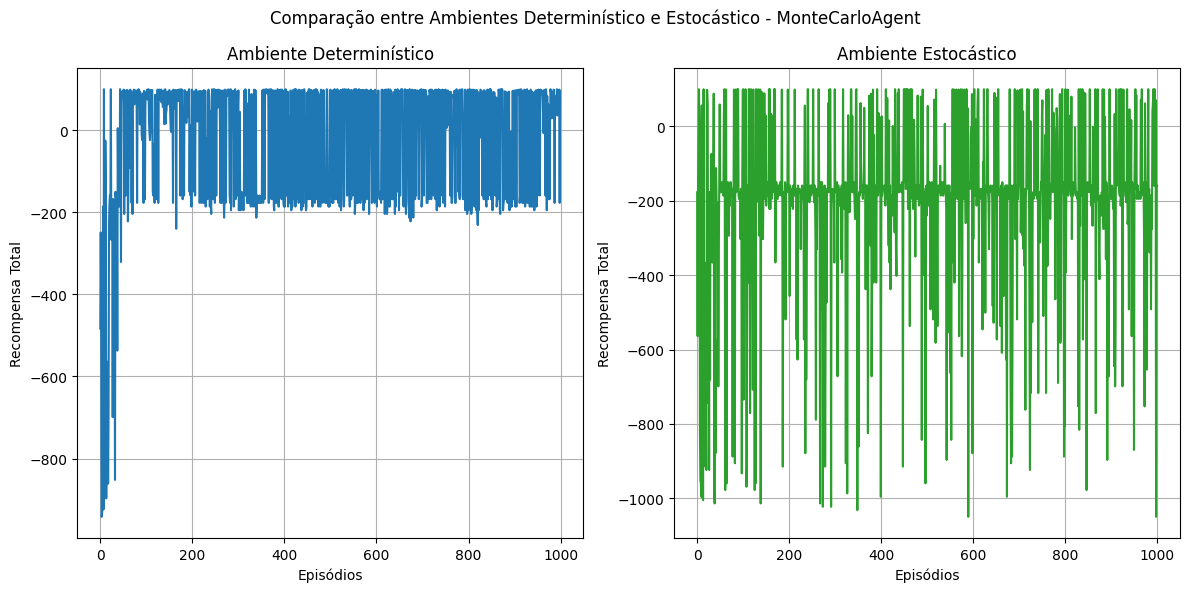

In [60]:
# Define the grid of parameters to test
param_grid = {
    'epsilon': [0.1, 0.5, 0.6],
    'gamma': [0.1, 0.6, 0.99],
    'alpha': [0.1, 0.5, 0.9]
}

# Number of obstacles to test
num_obstacles_list = [0, 2]

# Number of episodes to run for each experiment
episodes = 1000

# Number of maze to test
maze = 3

# Run the experiments
run_experiments(MonteCarloAgent, maze, episodes, num_obstacles_list, param_grid, save_plots=False, show_plots=False, render=False, max_steps=100)

# Open 0 CSV 
df = pd.read_csv(f'results/MonteCarloAgent.csv')
# Converte as strings de volta para arrays do NumPy
df['rewards'] = df['rewards'].apply(literal_eval)

# Pega o primeiro treinado para avaliar
rewards_deterministic = df[df['num_obstacles'] == 0]['rewards'].values[0]
rewards_stochastic = df[df['num_obstacles'] == 2]['rewards'].values[0]
plot_deterministic_vs_stochastic(rewards_deterministic, rewards_stochastic,method="MonteCarloAgent", show_plots=True, save_plots=False)

# Expande a coluna 'rewards', que contém listas, em várias linhas
df = df.explode('rewards')
# Converte os valores de 'rewards' para numéricos
df['rewards'] = pd.to_numeric(df['rewards'])
# Agrupa por 'alpha' e calcula a média das recompensas
grouped = df.groupby('alpha')['rewards'].mean()
# Prepara os dados para o gráfico
alpha_values = grouped.index.tolist()
average_rewards = grouped.values.tolist()
plot_sensitivity_analysis(alpha_values, average_rewards,parameter_name='alpha',metric_name='Recompensa Média',method="MonteCarloAgent",title='Análise de Sensibilidade para Alpha', show_plots=False, save_plots=False)

#### 5.1) Experimento do Monte Carlo com Aproximação de função linear

### 6) Experimento Q-Learning

**episódios** = 1000

**reward =** -1 quando mover sem obstáculos e -50 quando mover em paredes ou obstáculos -150 se passar de 100 movimentos no episódio

**alpha =** variável de acordo com a formula $\alpha_{t} = 1/N_(s_t, s_a)$

**gamma =** 0.1 , 0.6, 0.9, 0.99

**epsilon =**  de acordo com a formula $\epsilon_{t} = N0/(N0+N(st))$

**Ambiente =** Matriz 6 x 6 com obstáculo fixo ao centro 


In [61]:
# # Define the grid of parameters to test
param_grid = {
    'epsilon': [0.1, 0.5, 0.6],
    'gamma': [0.1, 0.6, 0.99],
    'alpha': [0.1, 0.5, 0.9]
}

# Number of obstacles to test
num_obstacles_list = [0, 2]

# Number of episodes to run for each experiment
episodes = 1000

# Number of maze to test
maze = 3

# Run the experiments
run_experiments(QLearningAgent, maze, episodes, num_obstacles_list, param_grid, save_plots=False, show_plots=False, render=False, max_steps=100)

# Open the CSV file with the results
df = pd.read_csv(f'results/QLearningAgent.csv')
# Converte as strings de volta para arrays do NumPy
df['rewards'] = df['rewards'].apply(literal_eval)

# Pega o primeiro treinado para avaliar
rewards_deterministic = df[df['num_obstacles'] == 0]['rewards'].values[0]
rewards_stochastic = df[df['num_obstacles'] == 2]['rewards'].values[0]
plot_deterministic_vs_stochastic(rewards_deterministic, rewards_stochastic,method="QLearningAgent" ,show_plots=False, save_plots=False)

# Expande a coluna 'rewards', que contém listas, em várias linhas
df = df.explode('rewards')
# Converte os valores de 'rewards' para numéricos
df['rewards'] = pd.to_numeric(df['rewards'])
# Agrupa por 'alpha' e calcula a média das recompensas
grouped = df.groupby('alpha')['rewards'].mean()
# Prepara os dados para o gráfico
alpha_values = grouped.index.tolist()
average_rewards = grouped.values.tolist()
plot_sensitivity_analysis(alpha_values, average_rewards,parameter_name='alpha',metric_name='Recompensa Média',method="QLearningAgent",title='Análise de Sensibilidade para Alpha', show_plots=False, save_plots=False)

QLearningAgent - 0 Obstacles - 0.01 Epsilon - 0.1 Gamma - 0.1 Alpha

Training Details:
+--------------------------+----------------+
|        Parameter         |     Value      |
+--------------------------+----------------+
|          Agent           | QLearningAgent |
|        Obstacles         |       0        |
|         Epsilon          |      0.01      |
|          Gamma           |      0.1       |
|          Alpha           |      0.1       |
|         Episodes         |      1000      |
| Execution Time (seconds) |      0.13      |
|      Success Count       |      993       |
+--------------------------+----------------+

Performance Metrics:
+------------+------------+---------------+
|   Metric   |  Episode   |     Value     |
+------------+------------+---------------+
| Max reward | Episode 24 | reward = 100  |
| Min reward | Episode 0  | reward = -190 |
| Max steps  | Episode 0  |  steps = 100  |
| Min steps  | Episode 24 |   steps = 1   |
+------------+------------+----

#### 6.1) Experimento do Q-Learning com Aproximação de função linear

C:\Users\juliano soares\AppData\Local\Temp\ipykernel_17692\3167324544.py:54: RuntimeWarning: invalid value encountered in scalar subtract
  self.theta += self.alpha * (target - predict) * current_features


AttributeError: 'LinearQLearningAgent' object has no attribute 'execute_optimal_policy'

: 

### 7) Experimento Sarsa

**episódios** = 1000

**reward =** -1 quando mover sem obstáculos e -50 quando mover em paredes ou obstáculos -150 se passar de 100 movimentos no episódio

**alpha =** variável de acordo com a formula $\alpha_{t} = 1/N_(s_t, s_a)$

**gamma =** 0.1 , 0.6, 0.9, 0.99

**epsilon =**  de acordo com a formula $\epsilon_{t} = N0/(N0+N(st))$

**Ambiente =** Matriz 6 x 6 com obstáculo fixo ao centro 


In [62]:
# # Define the grid of parameters to test
param_grid = {
    'epsilon': [0.1, 0.5, 0.6],
    'gamma': [0.1, 0.6, 0.99],
    'alpha': [0.1, 0.5, 0.9]
}

# Number of obstacles to test
num_obstacles_list = [0, 2]

# Number of episodes to run for each experiment
episodes = 1000

# Number of maze to test
maze = 3

# Run the experiments
run_experiments(SARSAgent, maze, episodes, num_obstacles_list, param_grid, save_plots=False, show_plots=False, render=False, max_steps=100)

# Open the CSV file with the results
df = pd.read_csv(f'results/SARSAgent.csv')
# Converte as strings de volta para arrays do NumPy
df['rewards'] = df['rewards'].apply(literal_eval)

# Pega o primeiro treinado para avaliar
rewards_deterministic = df[df['num_obstacles'] == 0]['rewards'].values[0]
rewards_stochastic = df[df['num_obstacles'] == 2]['rewards'].values[0]
plot_deterministic_vs_stochastic(rewards_deterministic, rewards_stochastic,method="SARSAgent" ,show_plots=False, save_plots=False)

# Expande a coluna 'rewards', que contém listas, em várias linhas
df = df.explode('rewards')
# Converte os valores de 'rewards' para numéricos
df['rewards'] = pd.to_numeric(df['rewards'])
# Agrupa por 'alpha' e calcula a média das recompensas
grouped = df.groupby('alpha')['rewards'].mean()
# Prepara os dados para o gráfico
alpha_values = grouped.index.tolist()
average_rewards = grouped.values.tolist()
plot_sensitivity_analysis(alpha_values, average_rewards,parameter_name='alpha',metric_name='Recompensa Média',method="SARSAgent",title='Análise de Sensibilidade para Alpha', show_plots=False, save_plots=False)

SARSAgent - 0 Obstacles - 0.01 Epsilon - 0.1 Gamma - 0.1 Alpha

Training Details:
+--------------------------+-----------+
|        Parameter         |   Value   |
+--------------------------+-----------+
|          Agent           | SARSAgent |
|        Obstacles         |     0     |
|         Epsilon          |   0.01    |
|          Gamma           |    0.1    |
|          Alpha           |    0.1    |
|         Episodes         |   1000    |
| Execution Time (seconds) |   1.59    |
|      Success Count       |    973    |
+--------------------------+-----------+

Performance Metrics:
+------------+------------+---------------+
|   Metric   |  Episode   |     Value     |
+------------+------------+---------------+
| Max reward | Episode 54 | reward = 100  |
| Min reward | Episode 0  | reward = -235 |
| Max steps  | Episode 0  |  steps = 100  |
| Min steps  | Episode 54 |   steps = 1   |
+------------+------------+---------------+

Performance Table:
+-----------------------+-------

#### 7.1) Experimento do SARSA com Aproximação de função linear

### 8) Comparação entre os algoritmos

In [63]:
# Open the CSV file with the results
df_MonteCarloAgent = pd.read_csv(f'results/MonteCarloAgent.csv')
df_QLearningAgent = pd.read_csv(f'results/QLearningAgent.csv')
df_SARSAAgent = pd.read_csv(f'results/SARSAgent.csv')

#### 1. Comparação do Tempo de Execução
Compara o tempo de execução de cada método.

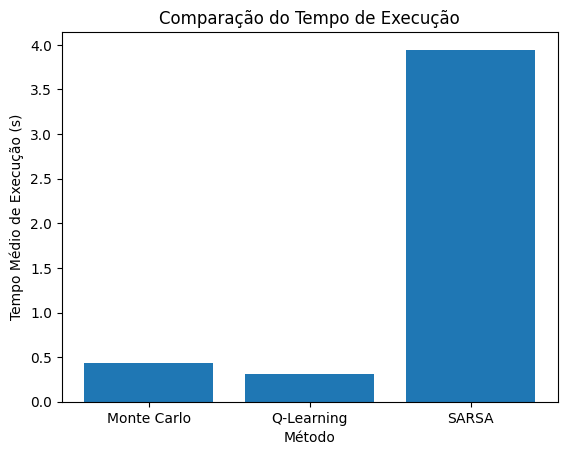

In [64]:
times = [df_MonteCarloAgent['execution_time'].mean(), df_QLearningAgent['execution_time'].mean(), df_SARSAAgent['execution_time'].mean()]
methods = ['Monte Carlo', 'Q-Learning', 'SARSA']

plt.bar(methods, times)
plt.xlabel('Método')
plt.ylabel('Tempo Médio de Execução (s)')
plt.title('Comparação do Tempo de Execução')
plt.show()

#### 2. Comparação da Taxa de Sucesso
Compara a taxa de sucesso de cada método.

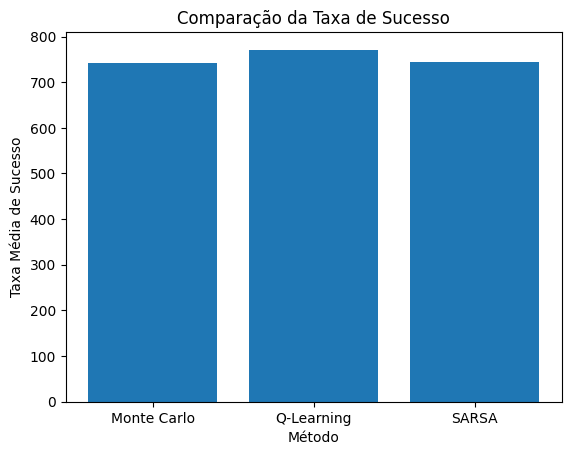

In [65]:
success_rates = [df_MonteCarloAgent['success_count'].mean(), df_QLearningAgent['success_count'].mean(), df_SARSAAgent['success_count'].mean()]

plt.bar(methods, success_rates)
plt.xlabel('Método')
plt.ylabel('Taxa Média de Sucesso')
plt.title('Comparação da Taxa de Sucesso')
plt.show()

#### 3. Melhores Conjuntos de Parâmetros
Identifica e exibe os melhores conjuntos de parâmetros para cada método baseado em critérios como recompensa total ou taxa de sucesso.

In [66]:
# Exemplo: identifica o conjunto de parâmetros com a maior taxa de sucesso para cada método
best_params_monte_carlo = df_MonteCarloAgent.loc[df_MonteCarloAgent['success_count'].idxmax()]
best_params_q_learning = df_QLearningAgent.loc[df_QLearningAgent['success_count'].idxmax()]
best_params_sarsa = df_SARSAAgent.loc[df_SARSAAgent['success_count'].idxmax()]

# Imprime os melhores conjuntos de parâmetros
print("Melhores Parâmetros Monte Carlo:\n", best_params_monte_carlo)
print("Melhores Parâmetros Q-Learning:\n", best_params_q_learning)
print("Melhores Parâmetros SARSA:\n", best_params_sarsa)


Melhores Parâmetros Monte Carlo:
 execution_time                                             0.159519
alpha                                                           0.5
gamma                                                          0.99
epsilon                                                         0.5
num_obstacles                                                     0
success_count                                                   998
failure_count                                                     2
rewards           [-456, -165, -339, -86, -87, 81, 88, -83, -317...
steps             [100, 77, 100, 34, 80, 11, 4, 49, 94, 13, 26, ...
visits            {(0, 0): 209, (0, 1): 206, (0, 2): 192, (0, 3)...
Name: 16, dtype: object
Melhores Parâmetros Q-Learning:
 execution_time                                             0.067357
alpha                                                           0.9
gamma                                                           0.6
epsilon                  